## Backpropagation
In this notebook we are going to deep in backpropagation instead of using autograd

In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

In [2]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2025-12-10 22:30:45--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2025-12-10 22:30:45 (7.95 MB/s) - ‘names.txt’ saved [228145/228145]



In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
block_size = 3 ## the memory
def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
def cmp(s,dt,t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [7]:
n_embd = 10
n_hidden = 60

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)

#Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3/(n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1

#Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1

# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C,W1,b1,W2,b2,bngain,bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

3897


In [8]:
batch_size = 32
n = batch_size

# construct minibatches
ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]

In [9]:
## forward pass

emb = C[Xb]
embcat = emb.view(emb.shape[0],-1)

hprebn = embcat @ W1 + b1
## BatchNorm Layer
bnmeani = 1/n*hprebn.sum(0,keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0,keepdim=True)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bndiff * bnvar_inv * bngain + bnbias

## non linearity (layer 1)
h = torch.tanh(hpreact)

## linear layer 2

logits = h @ W2 + b2

## cross entropy loss (same as F.cross_entropy)
logit_maxes = logits.max(1,keepdim=True).values
norm_logits = logits - logit_maxes

counts = norm_logits.exp()
counts_sum = counts.sum(1,keepdims=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n),Yb].mean()

## Backward pass
for p in parameters:
  p.grad = None

for t in [logprobs,probs,counts,counts_sum,counts_sum_inv,
          norm_logits,logit_maxes,logits,h,hpreact,bnraw,
          bnvar_inv,bnvar,bndiff2,bndiff,hprebn,bnmeani,
          embcat,emb]:
  t.retain_grad()

loss.backward()
loss

tensor(3.2635, grad_fn=<NegBackward0>)

In [10]:
logprobs.shape

torch.Size([32, 27])

In [11]:
## backprop the entire graph :)


#dLoss / dlogprobs.
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n),Yb] = -1.0 / n
cmp('logprobs',dlogprobs,logprobs)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0


In [12]:
logprobs[range(n),Yb].mean()

tensor(-3.2635, grad_fn=<MeanBackward0>)

In [13]:
dprobs = (1.0/ probs) * dlogprobs
cmp('probs',dprobs,probs)

probs           | exact: True  | approximate: True  | maxdiff: 0.0


In [14]:
dcounts_sum_inv = (counts * dprobs).sum(1,keepdim=True)
cmp('dcounts_sum_inv',dcounts_sum_inv,counts_sum_inv)
dcounts = counts_sum_inv * dprobs
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
cmp('dcounts_sum',dcounts_sum,counts_sum)
dcounts += torch.ones_like(counts) * dcounts_sum
cmp('counts',dcounts,counts)
dnorm_logits = (counts)* dcounts
cmp('norm_logits',dnorm_logits,norm_logits)

dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1,keepdim=True)


dcounts_sum_inv | exact: True  | approximate: True  | maxdiff: 0.0
dcounts_sum     | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0


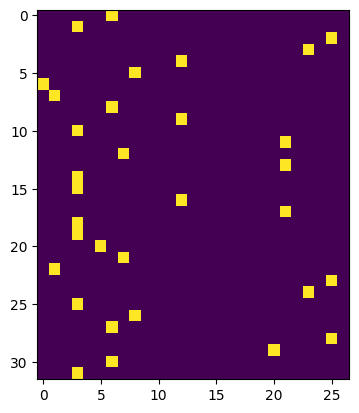

In [15]:
plt.imshow(F.one_hot(logits.max(1).indices,num_classes=logits.shape[1]))

In [16]:
dlogits += F.one_hot(logits.max(1).indices,num_classes=logits.shape[1]) * dlogit_maxes
cmp('logits',dlogits,logits)

logits          | exact: True  | approximate: True  | maxdiff: 0.0


In [17]:
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)

In [18]:
dhpreact = (1.0 - h**2)*dh

In [19]:
dbngain = (bnraw * dhpreact).sum(0,keepdim=True)
dbnraw = (bngain * dhpreact)
dbnbias = dhpreact.sum(0,keepdim=True)

In [20]:
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0,keepdim=True)
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv

In [21]:
dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar

In [22]:
dbndiff +=  (2*bndiff)* dbndiff2

In [23]:
dhprebn = dbndiff.clone()
dbnmeani = (-torch.ones_like(bndiff) * dbndiff).sum(0)

In [24]:
dhprebn += 1.0 / n * (torch.ones_like(hprebn) * dbnmeani)

In [25]:
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)

In [26]:
demb = dembcat.view(emb.shape)

In [27]:
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    ix = Xb[k,j]
    dC[ix] += demb[k,j]